In [1]:
%matplotlib inline 
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import itertools
from scipy import misc
import scipy.ndimage
import random
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
def gaussian_blur(sharp_image, sigma):
    blurred_image = scipy.ndimage.filters.gaussian_filter(sharp_image, sigma=sigma, order=0)
    return blurred_image

def uniform_blur(sharp_image, uniform_filter_size):
    multidim_filter_size = (uniform_filter_size, uniform_filter_size)
    blurred_image = scipy.ndimage.filters.uniform_filter(sharp_image, size=multidim_filter_size, mode='reflect')
    return blurred_image

def blur_image_locally(sharp_image, mask, use_gaussian_blur, gaussian_sigma, uniform_filter_size):
    # code from this SO answer: https://stackoverflow.com/a/54826758
    one_values_f32 = np.full(sharp_image.shape, fill_value=1.0, dtype=np.float32)
    sharp_image_f32 = sharp_image.astype(dtype=np.float32)
    sharp_mask_f32 = mask.astype(dtype=np.float32)

    if use_gaussian_blur:
        blurred_image_f32 = gaussian_blur(sharp_image_f32, sigma=gaussian_sigma)
        blurred_mask_f32 = gaussian_blur(sharp_mask_f32, sigma=gaussian_sigma)

    else:
        blurred_image_f32 = uniform_blur(sharp_image_f32, uniform_filter_size)
        blurred_mask_f32 = uniform_blur(sharp_mask_f32, uniform_filter_size)

    blurred_mask_inverted_f32 = one_values_f32 - blurred_mask_f32
    weighted_sharp_image = np.multiply(sharp_image_f32, blurred_mask_f32)
    weighted_blurred_image = np.multiply(blurred_image_f32, blurred_mask_inverted_f32)
    locally_blurred_image_f32 = weighted_sharp_image + weighted_blurred_image

    locally_blurred_image = locally_blurred_image_f32.astype(dtype=np.uint8)

    return locally_blurred_image

def chage_dot_color(picture, x, y, color):
    picture[x, y] = min(picture[x, y] + color, 255)
    return picture

def check_coords(img, x, y):
    """
    Check if coordinates are valid, if not, change them to closest vaue.
    """
    if x < 0: x = 0
    if y < 0: y = 0
    if x >= img.shape[0] : x = img.shape[0] - 1 
    if y >= img.shape[1] : y = img.shape[1] - 1
    return x, y

def get_mean_radius_color(img, x, y, radius):
    """
    Get the mean color of pixels around the given point.
    """
    colors_on_radius = []
    for y_img in range(y - radius, y + radius):
        for x_img in range(x - radius, x + radius):
            current_radius = math.sqrt((y_img - y)**2 + (x_img - x)**2)
            if current_radius < radius:
                x_img, y_img = check_coords(img, x_img, y_img)
                colors_on_radius.append(img[x_img, y_img])
    return sum(colors_on_radius) / len(colors_on_radius)

def change_radius_gradient_linear(picture, x, y, color, radius, original_color=None):
    """
    Create a gradient color shift around the point for a given radius.
    Linear interpolation is used.
    """

    r1 = 0
    c1 = color
    r2 = radius
    if original_color == None:
        c2 = get_mean_radius_color(picture, x, y, radius)
    else:
        c2 = original_color

    b = c1
    k = (c2 - c1) / r2

    for y_img in range(y - radius, y + radius):
        for x_img in range(x - radius, x + radius):
            x_img, y_img = check_coords(picture, x_img, y_img)
            current_radius = math.sqrt((y_img - y)**2 + (x_img - x)**2)
            if current_radius < radius:
                interpolated_color = k * current_radius + b
                x_img, y_img = check_coords(picture, x_img, y_img)
                chage_dot_color(picture=picture, x=x_img, y=y_img, color=interpolated_color)
    return picture

def get_proximity_coords(picture, x, y, radius):
    """
    Returns an array of coords of pixels around the point.
    """
    coords = []
    for y_img in range(y - radius, y + radius):
        for x_img in range(x - radius, x + radius):
            current_radius = math.sqrt((y_img - y)**2 + (x_img - x)**2)
            if current_radius < radius:
                x_img, y_img = check_coords(picture, x_img, y_img)
                tuple_ = (x_img, y_img)
                coords.append(tuple_)
    return coords

def generate_cluster(picture, x, y, color, radius, n_dots):
    """
    Generate a cluster of colored points, each one is randomly offset by one pixel.
    x, y - starting coordinates
    n_dots - number of points in the cluster
    color - color of the center point of the dot; the rest is colored with linear interpolation
    radius - radius of the dot, radius * 1.5 is used for the blurring radius

    Returns:
    picture - pertrubed image
    bb - cluster bounding box in imgaug format
    """
    steps = np.linspace(-2, 2, 4) # possible offsets between points in a cluster
    coords_list = []
    for _ in range(n_dots):
        coords = get_proximity_coords(picture, x, y, int(radius * 1.5)) # get a list of coordinates around each dot to blur
        coords_list = coords_list + coords
        change_radius_gradient_linear(picture, x, y, color, radius)
        x = int(x + np.random.choice(steps, 1))
        y = int(y + np.random.choice(steps, 1))
        x, y = check_coords(picture, x, y)
    tmp = []
    for elem in coords_list: # remove duplicates
        if elem not in tmp:
            tmp.append(elem)
    coords_list = tmp

    # create a mask to apply blur
    mask = np.ones((picture.shape[0], picture.shape[1]))
    for i in range(len(coords_list)):
        mask[coords_list[i]] = 0
    
    picture = blur_image_locally(
        picture,
        mask,
        use_gaussian_blur=False,
        gaussian_sigma=10,
        uniform_filter_size=radius)
    
    # create an inverted mask to create a bb
    mask = np.zeros((picture.shape[0], picture.shape[1]))
    for i in range(len(coords_list)):
        mask[coords_list[i]] = 1

    bb = mask_to_bb(mask)
    bb.label = 'defect'
    
    return picture, bb

def pertrube_image(image, mask, color, radius, n_dots, n_clusters):
    """
    Pertrube the image with a given number of clusters.
    image - sring with the path to an image.
    mask - mask of regions where the defects can be generated. 1 in the mask means it's a valid region for pertrubation 
    n_dots - number of points in the cluster
    color - color of the center point of the dot; the rest is colored with linear interpolation
    radius - radius of the dot, radius * 1.5 is used for the blurring radius
    n_clusters - number of clusters, i.e. number of individual defects

    Returns:
    img - pertrubed image
    bb_list - list of defect bounding boxes in imgaug format
    """
    bb_list = []
    img = image
    for _ in range(n_clusters):
        flag_hit = False
        while flag_hit == False:
            x = int(np.random.choice(img.shape[0], 1))
            y = int(np.random.choice(img.shape[1], 1))
            if mask[x, y] == 1.0:
                flag_hit = True
                img, bb = generate_cluster(img, x, y, color, radius, n_dots)
                bb_list.append(bb)
    return img, bb_list

def yolo_to_pascal_voc(x_center, y_center, w, h,  image_w, image_h):
    """ Converts yolo bounding boxes to bounding boxes of superior format."""
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w)/2
    y1 = ((2 * y_center * image_h) - h)/2
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

def mask_to_bb(mask):
    """Convert a mask of ones into a bounding box"""
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[y, x] == 1: # find the first values
                x_min = x_max = x
                y_min = y_max = y
                break
            
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[y, x] == 1:
                if x < x_min: x_min = x
                if x > x_max: x_max = x
                if y < y_min: y_min = y
                if y > y_max: y_max = y

    return BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)
    
def calc_background_color(image, mask):
    """Calculate the background color of the masked image.
    Basically the mean color of pixels where the mask is 0.
    """
    pixel_list =[]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x, y] == 0:
                pixel_list.append(image[x, y])
    return sum(pixel_list)/len(pixel_list)

def bb_to_yolo(image, bb):
    """Converts imgaug bounding boxes to bounding boxes of inferior yolo format."""
    x1 = bb.x1
    y1 = bb.y1
    x2 = bb.x2
    y2 = bb.y2
    label = bb.label
    image_w = image.shape[0]
    image_h = image.shape[1]
    return [((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h, label]

def draw_bb_yolo(image, bb):
    """Draws a yolo bb on an image. Poorly implemented, should be used for testing purposes only."""
    bb_pascal = yolo_to_pascal_voc(x_center=bb[0], y_center=bb[1], w=bb[2], h=bb[3], image_w=image.shape[0], image_h=image.shape[0])
    bb_pascal_int = []
    for item in bb_pascal:
        bb_pascal_int.append(int(item))
    return cv2.rectangle(image, pt1=(bb_pascal_int[0], bb_pascal_int[1]), 
                         pt2=(bb_pascal_int[2], bb_pascal_int[3]), color=(255, 0, 0), thickness=1)


def distort_image(image, mask):
    """The main method of creating image defects.
    image -  image to create defects on
    mask - a mask for the logo, an array with 1s as logo and 0s as everything else

    Returns:
    image_aug - image with applied defects and transforms
    bbs_aug - bounding boxes in imgaug format
    bbs_yolo - bounding boxes in yolo format
    """
    # number of defects and their probability
    probabilities = [0.05, 0.7, 0.2, 0.05]
    possible_defects = [0, 1, 2, 3]
    defect_count = np.random.choice(possible_defects, p=probabilities)

    # calculate the background color and vary it
    background_color = calc_background_color(image, mask)
    background_color = background_color * (1 + random.uniform(-0.05, 0.05))

    # generate defects
    image, bb_list = pertrube_image(image,
                                    mask,
                                    color=background_color,
                                    radius=2,
                                    n_dots=5,
                                    n_clusters=defect_count)
    
    # create a list of bounding boxes and labels
    bb_mask = mask_to_bb(mask)
    bb_mask.label = 'logo'
    bounding_boxes = bb_list
    bounding_boxes.append(bb_mask)
    # perform CropAndPad augmentation, padding with background_color
    background_color = calc_background_color(image, mask)
    # seq = iaa.Sequential([iaa.size.CropAndPad(percent=(-0.05, 0.05), pad_cval=255, keep_size=True)])
    image_w = image.shape[1]
    image_h = image.shape[0]
    seq = iaa.Sequential([iaa.size.Pad(percent=0.05, pad_cval=255, keep_size=False),
                          imgaug.augmenters.geometric.Rotate(rotate=(-5, 5), cval=255),
                          imgaug.augmenters.size.CropToFixedSize(width=image_w, height=image_h)])
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bounding_boxes)
    # change the color of the whole image
    image_aug = image_aug * (1 + random.uniform(-0.05, 0.05))
    # convert bounding boxes to yolo format
    bbs_yolo = []
    for bb in bbs_aug:
        bbs_yolo.append(bb_to_yolo(image_aug, bb))
    return image_aug, bbs_aug, bbs_yolo

In [3]:
# the actual pipeline:
# img = cv2.imread('/content/logo.jpg',0)
# mask = ...
# img_dist, bb_list, yolo_bbs = distort_image(img, mask)
# save img_dist and yolo_bbs in the format you like

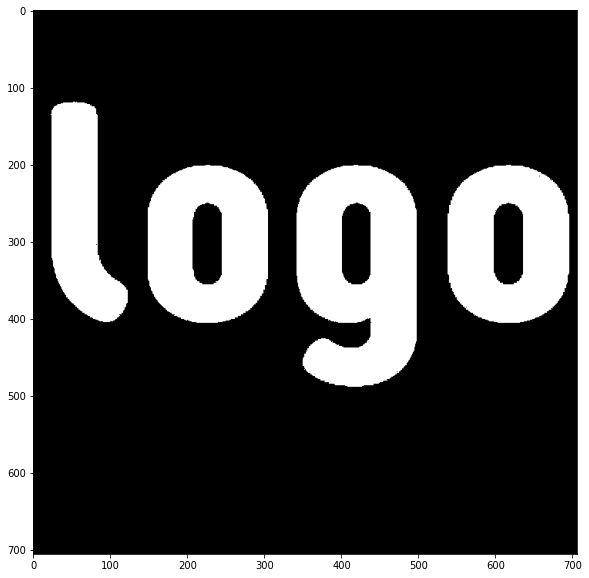

In [4]:
# mask visualization

img = cv2.imread('/content/logo2.jpg',0)
mask = np.full(img.shape, fill_value=0.0, dtype=np.float32)
for x in range(img.shape[1]):
    for y in range(img.shape[0]):
        if img[y, x] <= 25:
            mask[y, x] = 1
plt.imshow(mask, cmap='gray')

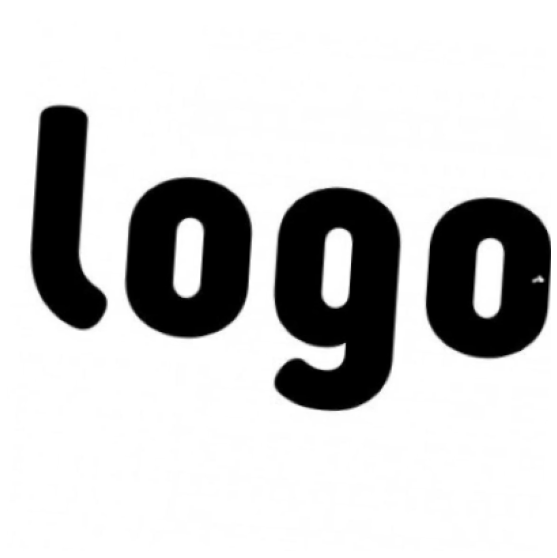

In [5]:
# code for creating different augmented images from one

plt.axis('off')
for i in range(10):
    img = cv2.imread('/content/logo2.jpg',0)
    img = cv2.resize(img, (400, 400)) 
    mask = np.full(img.shape, fill_value=0.0, dtype=np.float32)
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            if img[y, x] <= 25:
                mask[y, x] = 1
    img_dist, bb_list, yolo_bbs = distort_image(img, mask)
    plt.imshow(img_dist, cmap='gray')
    plt.savefig(str(i)+'.png', bbox_inches='tight', pad_inches=0)

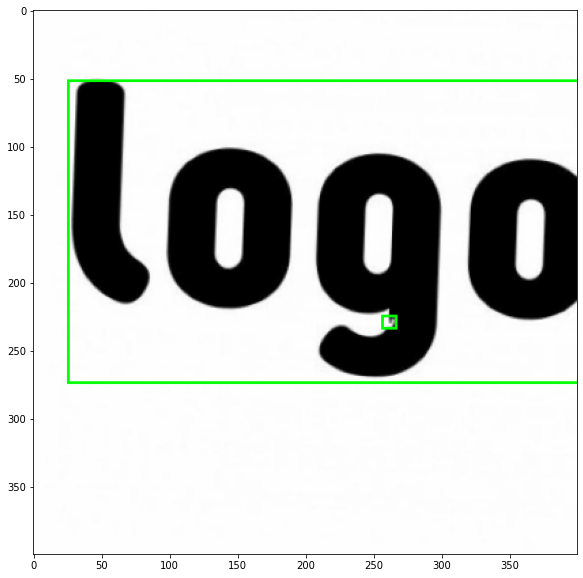

<Figure size 720x720 with 0 Axes>

In [11]:
# pipeline for visualization

img = cv2.imread('/content/logo2.jpg',0)
img = cv2.resize(img, (400, 400)) 
mask = np.full(img.shape, fill_value=0.0, dtype=np.float32)
for x in range(img.shape[1]):
    for y in range(img.shape[0]):
        if img[y, x] <= 3:
            mask[y, x] = 1
img_dist, bb_list, yolo_bbs = distort_image(img, mask)
img_dist = img_dist.astype(np.uint8)
img_dist = cv2.cvtColor(img_dist, cv2.COLOR_GRAY2BGR)
for bb in bb_list:
    img_dist = bb.draw_box_on_image(img_dist, size=2)
    # img_dist = bb.draw_on_image(img_dist, size=2)
plt.imshow(img_dist, cmap='gray')
plt.show()
plt.savefig(str(i)+'.png', bbox_inches='tight', pad_inches=0)

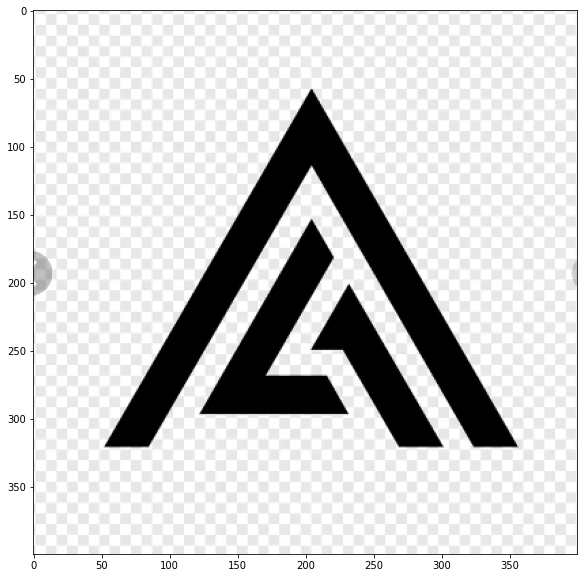

In [6]:
# read an example image
img_orig = cv2.imread('/content/logo.jpg',0)
img_orig = cv2.resize(img_orig, (400, 400)) 
plt.imshow(img_orig, cmap='gray')
plt.show()

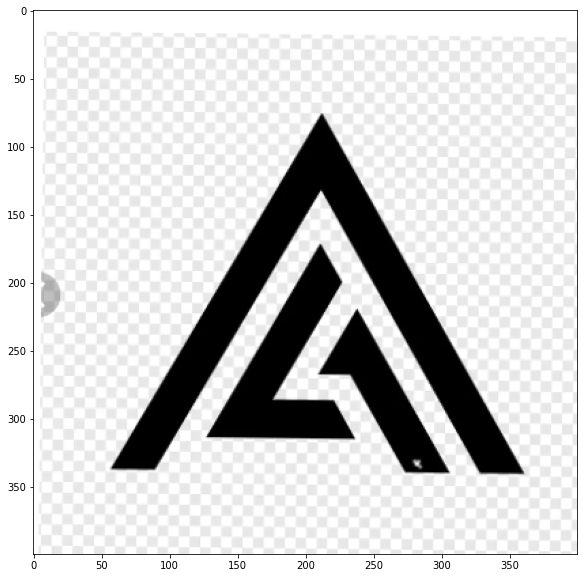

In [7]:
img = img_orig
# get a logo mask for it
mask = np.full(img.shape, fill_value=0.0, dtype=np.float32)
for x in range(img.shape[1]):
    for y in range(img.shape[0]):
        if img[y, x] <= 3:
            mask[y, x] = 1
# generate defects
img_dist, bb_list, yolo_bbs = distort_image(img, mask)
plt.imshow(img_dist, cmap='gray')
plt.show()

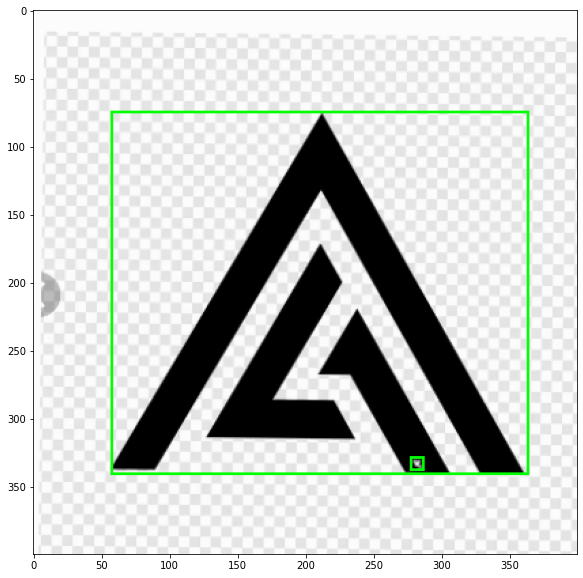

In [8]:
# visualize bounding boxes

img_dist = img_dist.astype(np.uint8)
img_dist = cv2.cvtColor(img_dist, cv2.COLOR_GRAY2BGR)
for bb in bb_list:
    img_dist = bb.draw_box_on_image(img_dist, size=2)
    # img_dist = bb.draw_on_image(img_dist, size=2)
plt.imshow(img_dist, cmap='gray')
plt.show()

In [ ]:
# for bb in yolo_bbs:
#     img_dist = draw_bb_yolo(img_dist, bb)
# plt.imshow(img_dist, cmap='gray')
# plt.show()